# Tagging genes with ddlite

## Introduction
In this example **ddlite** app, we'll build a gene tagger from scratch. Here's why we developed ddlite:

* To provide a lighter-weight interface to structured information extraction for new DeepDive users
* To help advanced DeepDive rapidly develop and prototype applications and distant supervision rules
* To investigate DeepDive's data programming approach to building inference systems

This example is centered around the second item. Domain-specific tagging systems take months or years to develop. They use hand-crafted model circuitry and accurate, hand-labeled training data. We're going to try to build a pretty good one in a few minutes with none of those things. The generalized extraction and learning utilities provided by ddlite will allow us to turn a sampling of article abstracts and some basic domain knowledge into an automated tagging system. Specifically, we want an accurate tagger for genes in academic articles. We have comprehensive dictionaries of genes, but applying a simple matching rule might yield a lot of false positives. For example, "p53" might get tagged as a gene if it refers to a page number. Our goal is to use distant supervision to improve precision.

Here's the pipeline we'll follow:

1. Obtain and parse input data (relevant article abstracts from PubMed)
2. Extract candidates for tagging
3. Generate features
4. Write distant supervision rules
5. Learn the tagging model

Let's get to it.

In [1]:
%load_ext autoreload
%autoreload 2

import cPickle
from ddlite import *

/home/henryre/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Processing the input data
We already downloaded the raw HTML for ??? gene-related article pages from PubMed using the **pubmed_gene_html.py** script. These can be found in the **data** folder. We can use ddlite's **DocParser** to read in the article text. There's a general HTML parser which finds visible text, but we can do better by writing a more specific version to just grab the abstract text.

In [2]:
class PubMedAbstractParser(HTMLParser):
    def _cleaner(self, s):
        return (s.parent.name == 'abstracttext')

dp = DocParser('gene_tag_example/data/', PubMedAbstractParser())
docs = list(dp.parseDocs())
print docs[0]

Mutations in BCS1L, a respiratory chain complex III assembly chaperone, constitute a major cause of mitochondrial complex III deficiency and are associated with GRACILE and Bjrnstad syndromes. Here we describe a 4-year-old infant with hyperlactacidemia, mild liver dysfunction, hypotonia, growth and psychomotor retardation, dysmorphic features and mitochondrial complex III deficiency. Respiratory chain enzyme activities showed an isolated complex III defect in muscle and fibroblasts. Sequencing and polymerase chain reaction-restriction fragment length polymorphism (PCR-RFLP) analysis revealed a novel homozygous BCS1L mutation, c.148A>G, which caused a p.T50A substitution at an evolutionarily conserved BCS1L region. The severity of the complex III enzyme defect correlated with decreased amounts of BCS1L and respiratory chain complex III in the affected tissues. Our findings support a pathogenic role for the novel BCS1L mutation in a patient with a singular clinical phenotype.


Now we'll use CoreNLP via ddlite's SentenceParser to parse each sentence. **DocParser** can handle this too; we didn't really need that call above. This can take a little while, so if the example has already been run, we'll reload it.

In [3]:
docs = None

pkl_f = 'gene_tag_example/gene_tag_saved_sents_v2.pkl'
try:
    with open(pkl_f, 'rb') as f:
        sents = cPickle.load(f)
except:
    %time sents = dp.parseDocSentences()
    with open(pkl_f, 'w+') as f:
        cPickle.dump(sents, f)

print sents[0]

Sentence(words=['Mutations', 'in', 'BCS1L', ',', 'a', 'respiratory', 'chain', 'complex', 'III', 'assembly', 'chaperone', ',', 'constitute', 'a', 'major', 'cause', 'of', 'mitochondrial', 'complex', 'III', 'deficiency', 'and', 'are', 'associated', 'with', 'GRACILE', 'and', 'Bjrnstad', 'syndromes', '.'], lemmas=['mutation', 'in', 'bcs1l', ',', 'a', 'respiratory', 'chain', 'complex', 'iii', 'assembly', 'chaperone', ',', 'constitute', 'a', 'major', 'cause', 'of', 'mitochondrial', 'complex', 'iii', 'deficiency', 'and', 'be', 'associate', 'with', 'gracile', 'and', 'bjrnstad', 'syndrome', '.'], poses=['NNS', 'IN', 'NN', ',', 'DT', 'JJ', 'NN', 'NN', 'CD', 'NN', 'NN', ',', 'VBP', 'DT', 'JJ', 'NN', 'IN', 'JJ', 'NN', 'CD', 'NN', 'CC', 'VBP', 'VBN', 'IN', 'NN', 'CC', 'NN', 'NNS', '.'], dep_parents=[13, 3, 1, 3, 11, 11, 11, 11, 11, 11, 3, 3, 0, 16, 16, 13, 21, 21, 21, 21, 16, 13, 24, 13, 26, 24, 26, 29, 26, 13], dep_labels=['nsubj', 'case', 'nmod', 'punct', 'det', 'amod', 'compound', 'compound', 'nu

## Extracting candidates
Extracting candidates for mentions (or relations) is a one-liner in ddlite. We have access to a pretty comprehensive gene dictionary. This will give use high recall, so again, our objective is to cut down on false positives. Let's load in the dictionary and create our candidate mentions in an **Entities** object.

In [4]:
# Schema is: ENSEMBL_ID | NAME | TYPE (refseq, canonical, non-canonical)
genes = [line.rstrip().split('\t')[1] for line in open('gene_tag_example/dicts/ensembl_genes.tsv')]
genes = filter(lambda g : len(g) > 2, genes)

ents = Entities(DictionaryMatch('Gene', genes, ignore_case=False), sents)

We can visualize contexts for our extractions too.

In [5]:
ents.entities[0].render()

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 Mutations in BCS1L , a respiratory chain complex III assembly chaperone , constitute a major cause of mitochondrial complex III deficiency and are associated with GRACILE and Bjrnstad syndromes .

## Generating features
Feature extraction is push-button in ddlite. We extract a number of generic features from the NLP markup and dependency tree in the vicinity of the mention.

In [6]:
ents.extract_features()
print "Extracted {} features for each of {} mentions".format(ents.num_feats(), ents.num_extractions())

Extracted 18025 features for each of 711 mentions


## Writing distant supervision rules
Candidate and feature extraction are really simple in ddlite. Writing distant supervision rules is where artistry comes in. One of ddlite's goals is to enable rapid prototyping and experimenting with distant supervision rules, either to create a simple standalone app, or to plug your findings into DeepDive. Rules must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). For now, we'll write a few simple rules to get started:

* The first rule returns a positive label if the mention candiate contains the word "gene", and abstains otherwise
* The second rule returns a positive label if the dependency parent of any of the words in the mention is "mutation", and abstains otherwise

In [7]:
def rule_1(m):
    return 1 if 'gene' in [m.lemmas[i] for i in m.idxs] else 0
def rule_2(m):
    return 1 if 'mutation' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0

The two rules given above won't yield a good model (especially since there are no negative examples). To create meaningful results, write more distant supervision rules! After writing the rules, we simply collect them and apply them to mentions. If we define more rules later, we can apply them incrementally.

In [8]:
rules = [rule_1, rule_2]
ents.apply_rules(rules)
print "Applied {} rules to {} mentions with {} positives, {} abstains, and {} negatives.".format(ents.num_rules(),
        ents.num_extractions(), ents.num_rules('pos'), ents.num_rules('abs'), ents.num_rules('neg'))

Applied 2 rules to 711 mentions with 39 positives, 1383 abstains, and 0 negatives.


## Learning
To learn weights for the features and rules, we use a simple, regularized logistic regression model. Again, the results won't be meaningful without more rules.

In [9]:
%time ents.learn_feats_and_weights(nSteps=5000, sample=False, mu=1e-6, holdout=0.1, use_sparse=True, verbose=True)


Learning epoch =  0	100	200	300	400	
Learning epoch =  500	600	700	800	900	
Learning epoch =  1000	1100	1200	1300	1400	
Learning epoch =  1500	1600	1700	1800	1900	
Learning epoch =  2000	2100	2200	2300	2400	
Learning epoch =  2500	2600	2700	2800	2900	
Learning epoch =  3000	3100	3200	3300	3400	
Learning epoch =  3500	3600	3700	3800	3900	
Learning epoch =  4000	4100	4200	4300	4400	
Learning epoch =  4500	4600	4700	4800	4900	CPU times: user 11.4 s, sys: 64 ms, total: 11.4 s
Wall time: 11.5 s


We can examine the learned weights for each feature and rule

In [10]:
print "Rule weights: {}".format(ents.w[:ents.num_rules()])
print "Some feature weights: {}".format(ents.w[ents.num_rules():ents.num_rules()+10])

Rule weights: [ 0.99995     1.03187806]
Some feature weights: [ 0.0007094   0.00044168  0.00064756  0.0010301   0.00112599  0.000868
  0.00061247  0.00166207  0.00141827  0.00098652]


or look at the predicted probability of each mention candidate being an actual gene mention

In [11]:
print "Some predicted mention probabilities: {}".format(ents.get_predicted_probability()[:10])

Some predicted mention probabilities: [ 0.96231716  0.97652766  0.90887477  0.90493521  0.97680272  0.89548014
  0.94513339  0.84978339  0.88611093  0.89561785]


We can use [DeepDive-style calibration plots](http://deepdive.stanford.edu/calibration) to evaluate the quality of our predictions. We aren't using a holdout set right now, so let's just look at the histogram of probabilities.

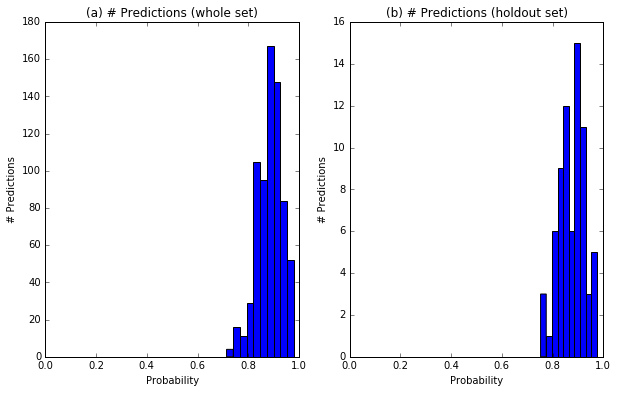

In [12]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)

ents.plot_calibration()

## Error Analysis

Now, let's look at a sample of extractions using [Mindtagger](http://deepdive.stanford.edu/labeling).  We can use a shorthand to create a Mindtagger task and launch it right from the notebook:

In [13]:
ents.open_mindtagger(num_sample=20, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


In [ ]:
tags = ents.get_mindtagger_tags()
print tags

In [ ]:
tagged_exts = [tag for tag in tags if u'is_correct' in tag]
num_correct = sum(1 for tag in tagged_exts if tag[u'is_correct'])
"precision = %3.f%%" % (100 * num_correct * 1.0 / len(tagged_exts))